### Init

In [118]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import logging
from pathlib import Path
import configparser

from astropy.table import Table
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from lmfit import fit_report
import numpy as np
import matplotlib.pyplot as plt

from gaussian_model import SingleGaussian, DoubleGaussian
from image import Image

#### Config ####
constants = configparser.ConfigParser()
constants.read('res/constants.ini')

data_folder = 'res/images'
min_distance = 50 # minimum distance between stars to perform Gaussian
dates = {'4-25-2021': [f'_{x}' for x in 'V'],
         '5-13-2021': [f'_{x}' for x in 'V'],
         '5-17-2021': [f'_{x}' for x in 'V'], # 5-19-2021 is bad
         '5-24-2022': [f'_{x}' for x in 'V'],
         '6-9-2022': [f'_{x}' for x in 'ABCDEFGHJK'], 
         '7-7-2022': [f'_{x}' for x in 'ABCDEFGHI']}
date = '7-7-2022'
indices = dates[date]

#### Logging ####
log = logging.getLogger('psfphot')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger('parso.python.diff').disabled = True # turn off IPython debugging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

verbose=False
logging.getLogger('image').setLevel(logging.DEBUG if verbose else logging.INFO)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Set up constants.ini
for date in dates:
    log.info(date)
    indices = dates[date]
    if not constants.has_section(f'{date}'):
        constants.add_section(f'{date}')

    # Get header info
    for index in indices:
        if not constants.has_section(f'{date}{index}'):
            constants.add_section(f'{date}{index}')
        fn = f'{data_folder}/{date}/pluto{index}'
        image = Image(fn)
        constants[f'{date}{index}']['obs_time'] = image.get_image_hdu_value('DATE-OBS')
        if index == indices[0]:
            constants[f'{date}']['start'] = constants[f'{date}{index}']['obs_time']
            constants[f'{date}']['pix_scale_x'] = str(image.get_image_hdu_value('CDELT2'))
            constants[f'{date}']['pix_scale_y'] = str(image.get_image_hdu_value('CDELT1'))
            constants[f'{date}']['subimage_dim'] = str(int(60 * .34 / float(constants[f'{date}']['pix_scale_x'])))
        if index == indices[-1]:
            constants[f'{date}']['end'] = constants[f'{date}{index}']['obs_time']
        constants.write(Path('res/constants.ini').open('w'))

    # Query apparent magnitude from JPL Horizons ephemeris
    pluto = Horizons(id=999, location=792, epochs=Time(constants[f'{date}']['start']).jd).ephemerides()
    pluto_vmag = pluto['V'][0]
    constants[f'{date}']['pluto_vmag'] = str(pluto_vmag)
    charon = Horizons(id='Charon', location=792, epochs=Time(constants[f'{date}']['start']).jd).ephemerides()
    charon_vmag = charon['V'][0]
    constants[f'{date}']['charon_vmag'] = str(charon_vmag)
    constants[f'{date}']['rel_flux'] = str(10**-((charon_vmag-pluto_vmag)/2.5))
    constants[f'{date}']['dx_guess'] = str((charon['RA'][0] - pluto['RA'][0])*3600 / float( constants[f'{date}']['pix_scale_x']))
    constants[f'{date}']['dy_guess'] = str(-(charon['DEC'][0] - pluto['DEC'][0])*3600 / float( constants[f'{date}']['pix_scale_y']))
    """
    RA increases to the right and DEC increases down. Does not depend on north-up value.
    """
    constants.write(Path('res/constants.ini').open('w'))


INFO:psfphot:4-25-2021
INFO:psfphot:5-13-2021
INFO:psfphot:5-17-2021
INFO:psfphot:5-24-2022
INFO:psfphot:6-9-2022
INFO:psfphot:7-7-2022


### Analyze star nearby Pluto and Charon to estimate $\sigma_x$, $\sigma_y$, and $\theta$

In [119]:
used_dates = ['6-9-2022']
for date in used_dates:
    indices = dates[date]
    dim = int(constants[f'{date}']['subimage_dim']) # n by n dimension of subimage
    for index in indices:
        log.info(f'{date}{index}')
        path = f'{data_folder}/{date}/pluto{index}.fits'
        entry = constants[f'{date}{index}']
        image = Image(path).subimage(entry['ref_star_x'], entry['ref_star_y'], dim, dim)
        image.write_fits(f'res/images/{date}/refstar{index}.fits')
        psfinit = {}
        psfinit['a'] = 500
        psfinit['bg'] = 500
        psfinit['xc'] =  dim/2
        psfinit['yc'] = dim/2
        psfinit['theta'] = 0
        psfinit['sigma_x'] = 5
        psfinit['sigma_y'] = 5

        psf = SingleGaussian(psfinit, image)
        psf.set_vary(['a', 'bg', 'xc', 'yc', 'theta', 'sigma_x', 'sigma_y'])
        psf.set_limits('a', 100, 100000)
        psf.set_limits('bg', 100, 10000)
        psf.set_limits('xc', 0, dim)
        psf.set_limits('yc', 0, dim)
        psf.set_limits('sigma_x', 0, 50)
        psf.set_limits('sigma_y', 0, 50)
        params = psf.run_minimizer()
        log.info(psf.get_result())
        log.info(fit_report(params, show_correl=False))

        entry['sigma_x'] = str(params['sigma_x'].value)
        entry['sigma_y'] = str(params['sigma_y'].value)
        entry['theta'] = str(params['theta'].value*180/np.pi % 360)
        constants.write(Path('res/constants.ini').open('w'))
        


INFO:psfphot:6-9-2022_A
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a:        564.685494 +/- 1.22436589 (0.22%) (init = 500)
    bg:       496.057525 +/- 0.15926148 (0.03%) (init = 500)
    xc:       29.3550943 +/- 0.01114208 (0.04%) (init = 30)
    yc:       29.3972613 +/- 0.01298198 (0.04%) (init = 30)
    theta:   -9.07789991 +/- 0.00762008 (0.08%) (init = 0)
    sigma_x:  4.99880301 +/- 0.01119930 (0.22%) (init = 5)
    sigma_y:  6.10474394 +/- 0.01367703 (0.22%) (init = 5)
INFO:psfphot:6-9-2022_B
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a:        667.082265 +/- 1.37668961 (0.21%) (init = 500)
    bg:       497.083527 +/- 0.16334907 (0.03%) (init = 500)
    xc:       29.9608621 +/- 0.00994880 (0.03%) (init = 30)
    yc:       28.5792846 +/- 0.01135561 (0.04%) (init = 30)
    theta:   -9.05700956 +/- 0.00809827 (0.09%) (init = 0)
    sigma_x:  4.69177778 +/- 0.00995155 (0.21%) (init = 5)
    sig

KeyboardInterrupt: 

### Use above values to fit Pluto and Charon psf

In [120]:
used_dates = ['6-9-2022']
for date in used_dates:
    indices = dates[date]
    dim = int(constants[f'{date}']['subimage_dim']) # n by n dimension of subimage
    for index in indices:
        log.info(f'{date}{index}')
        path = f'{data_folder}/{date}/pluto{index}.fits'
        entry = constants[f'{date}{index}']
        image = Image(path).subimage(entry['pluto_charon_x'], entry['pluto_charon_y'], dim, dim)
        image.write_fits(f'res/images/{date}/pluto_charon{index}.fits')
        psfinit = {}
        psfinit['a_p'] = 250
        psfinit['rel_flux'] = float(constants[f'{date}'][f'rel_flux'])
        psfinit['bg'] = 500
        psfinit['x_p'] =  dim/2
        psfinit['y_p'] = dim/2
        psfinit['dx'] = float(constants[f'{date}'][f'dx_guess'])
        psfinit['dy'] = float(constants[f'{date}'][f'dy_guess'])
        psfinit['theta'] = float(entry['theta']) * np.pi/180
        psfinit['sigma_x'] = float(entry['sigma_x'])
        psfinit['sigma_y'] = float(entry['sigma_y'])

        psf = DoubleGaussian(psfinit, image)
        psf.set_vary(['a_p', 'bg', 'x_p', 'y_p', 'dx', 'dy'])
        psf.set_limits('a_p', 100, 100000)
        psf.set_limits('bg', 100, 10000)
        psf.set_limits('x_p', 0, dim)
        psf.set_limits('y_p', 0, dim)
        limit = 8.5 * .34 / float(constants[f'{date}'][f'pix_scale_x'])
        psf.set_limits('dx', -limit, limit)
        psf.set_limits('dy', -limit, limit)
        params = psf.run_minimizer()
        log.info(psf.get_result())
        log.info(fit_report(params, show_correl=False))

        entry['dx'] = str(params['dx'].value)
        entry['dy'] = str(params['dy'].value)
        constants.write(Path('res/constants.ini').open('w'))


INFO:psfphot:6-9-2022_A
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a_p:       241.892811 +/- 0.54497567 (0.23%) (init = 250)
    rel_flux:  0.1808007 (fixed)
    bg:        497.988244 +/- 0.08456578 (0.02%) (init = 500)
    x_p:       25.3573878 +/- 0.01916729 (0.08%) (init = 30)
    y_p:       33.9980366 +/- 0.02984825 (0.09%) (init = 30)
    dx:       -4.24576950 +/- 0.13161841 (3.10%) (init = -2.435294)
    dy:        1.46505512 +/- 0.19154200 (13.07%) (init = 0.3176471)
    theta:     3.488471 (fixed)
    sigma_x:   4.998803 (fixed)
    sigma_y:   6.104744 (fixed)
INFO:psfphot:6-9-2022_B
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a_p:       283.448387 +/- 0.57532409 (0.20%) (init = 250)
    rel_flux:  0.1808007 (fixed)
    bg:        498.107584 +/- 0.08267084 (0.02%) (init = 500)
    x_p:       28.5902146 +/- 0.01487694 (0.05%) (init = 30)
    y_p:       33.9814824 +/- 0.02294569 (0.07%) (init =

### Plot pluto and charon results

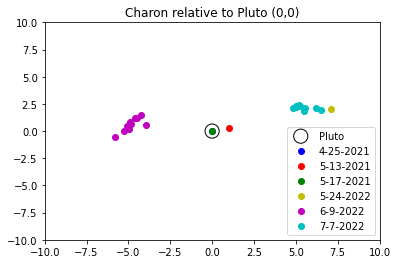

In [122]:
colors = ['b', 'r', 'g', 'y', 'm', 'c']
dxs = []
dys = []
for date in dates:
    indices = dates[date]
    dxs.append([float(constants[f'{date}{index}']['dx']) for index in indices])
    dys.append([float(constants[f'{date}{index}']['dy']) for index in indices])

plt.figure()
plt.title(f'Charon relative to Pluto (0,0)')
plt.xlim((-10,10))
plt.ylim((-10,10))
i = 0
plt.scatter([0], [0], s=200,facecolors='none', edgecolors='k', marker='o', label='Pluto')
for dx, dy in zip(dxs, dys):
    plt.scatter(dx, dy, c=colors[i], label=list(dates.keys())[i])
    i += 1
plt.legend()
plt.show()